Precisión del modelo KNN (PCA): 0.88
Precisión del modelo SVM (PCA): 0.78
Precisión del modelo BAC (PCA): 0.74
Precisión del modelo KNN (LDA): 0.93
Precisión del modelo SVM (LDA): 0.90
Precisión del modelo BAC (LDA): 0.96


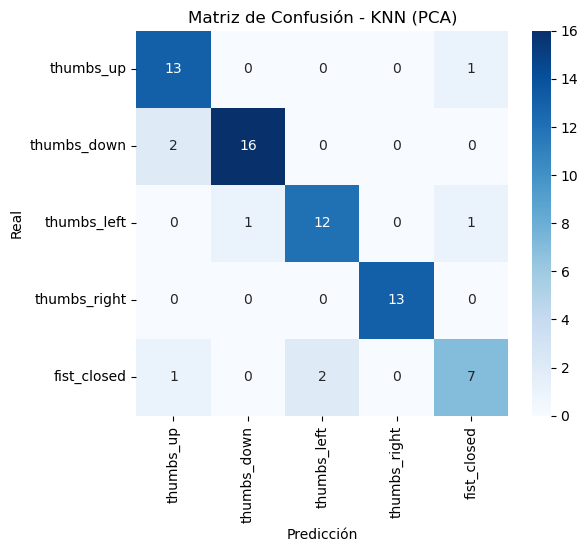

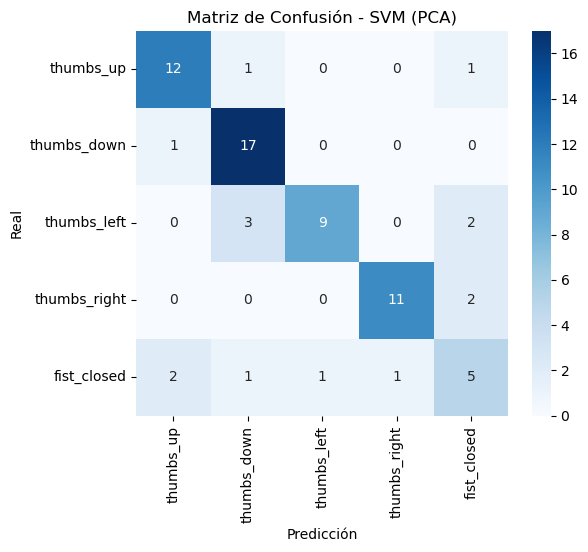

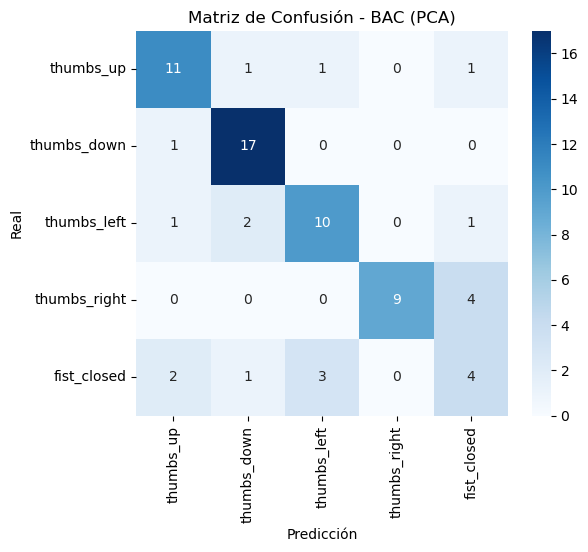

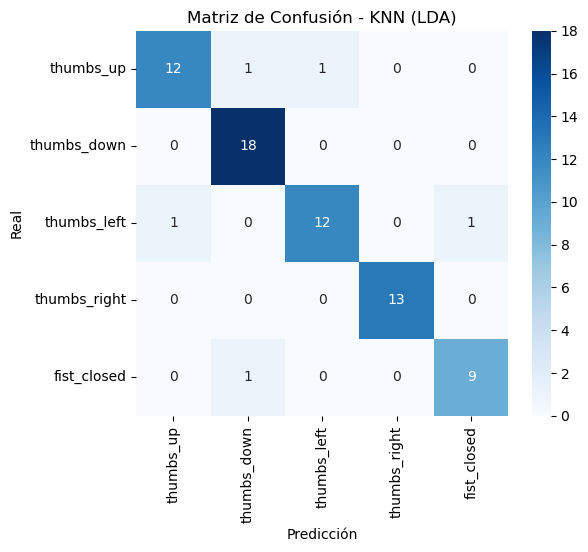

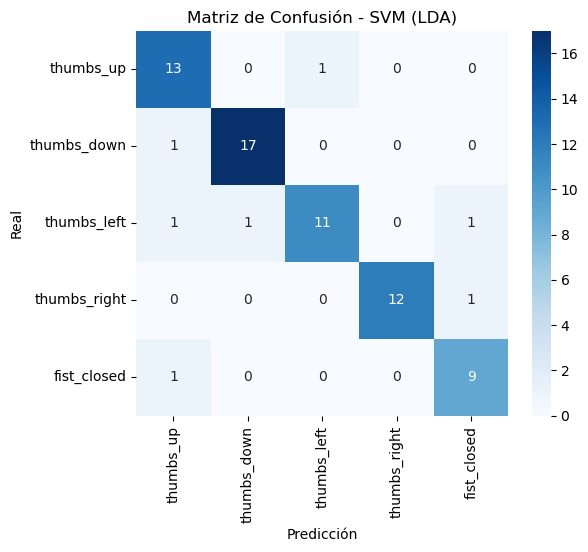

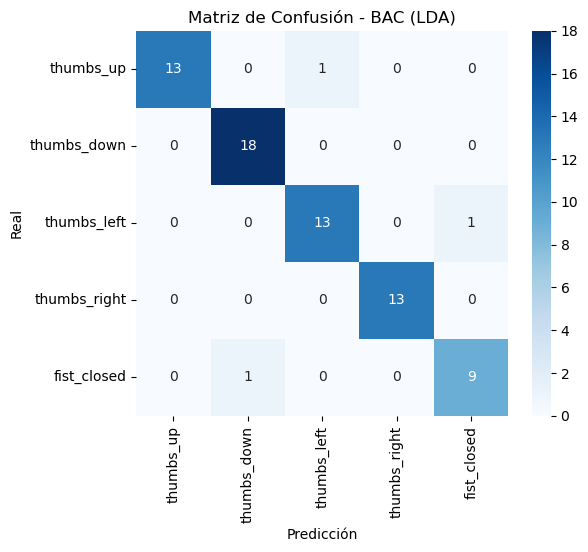

Modelos entrenados y guardados exitosamente.


In [16]:
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin

# Parámetros
n_neighbors = 5  # Número de vecinos para KNN
n_components = 10  # Número de componentes para reducción de dimensión

# Directorios con imágenes de las clases
dataset_path = "dataset"
labels_map = {"thumbs_up": 0, "thumbs_down": 1, "thumbs_left": 2, "thumbs_right": 3, "fist_closed": 4}

# Invertir labels_map para visualización
labels_map_inv = {v: k for k, v in labels_map.items()}

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Aplicar un pooling 4x4
    pooled_image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4), interpolation=cv2.INTER_AREA)
    
    edges = cv2.Canny(pooled_image, 50, 150)
    return edges

def extract_features(image):
    # Aplicar FFT y obtener la magnitud del espectro
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)
    return magnitude_spectrum.flatten()

# Implementación del clasificador Balanced Center (BAC)
class BalancedCenterClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.class_centers_ = {}
        for label in np.unique(y):
            self.class_centers_[label] = np.mean(X[y == label], axis=0)
        return self
    
    def predict(self, X):
        predictions = []
        for sample in X:
            distances = {label: np.linalg.norm(sample - center) for label, center in self.class_centers_.items()}
            predictions.append(min(distances, key=distances.get))
        return np.array(predictions)

# Cargar y procesar los datos
data, labels = [], []
for label_name, label in labels_map.items():
    folder_path = os.path.join(dataset_path, label_name)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        edges = preprocess_image(file_path)
        features = extract_features(edges)
        data.append(features)
        labels.append(label)

# Convertir a numpy array
data = np.array(data)
labels = np.array(labels)

# Aplicar reducción de dimensionalidad (PCA y LDA)
pca = PCA(n_components=n_components)
lda = LDA()
data_pca = pca.fit_transform(data, labels)
data_lda = lda.fit_transform(data, labels)

# Dividir los datos en entrenamiento y prueba
X_train_pca, X_test_pca, y_train, y_test = train_test_split(data_pca, labels, test_size=0.2, random_state=42)
X_train_lda, X_test_lda, _, _ = train_test_split(data_lda, labels, test_size=0.2, random_state=42)

# Entrenar modelos con PCA
knn_pca = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_pca.fit(X_train_pca, y_train)
svm_pca = SVC(kernel='linear')
svm_pca.fit(X_train_pca, y_train)
bac_pca = BalancedCenterClassifier()
bac_pca.fit(X_train_pca, y_train)

# Entrenar modelos con LDA
knn_lda = KNeighborsClassifier(n_neighbors=n_neighbors)
knn_lda.fit(X_train_lda, y_train)
svm_lda = SVC(kernel='linear')
svm_lda.fit(X_train_lda, y_train)
bac_lda = BalancedCenterClassifier()
bac_lda.fit(X_train_lda, y_train)

# Evaluar modelos
y_pred_knn_pca = knn_pca.predict(X_test_pca)
y_pred_svm_pca = svm_pca.predict(X_test_pca)
y_pred_bac_pca = bac_pca.predict(X_test_pca)
y_pred_knn_lda = knn_lda.predict(X_test_lda)
y_pred_svm_lda = svm_lda.predict(X_test_lda)
y_pred_bac_lda = bac_lda.predict(X_test_lda)

accuracy_knn_pca = accuracy_score(y_test, y_pred_knn_pca)
accuracy_svm_pca = accuracy_score(y_test, y_pred_svm_pca)
accuracy_bac_pca = accuracy_score(y_test, y_pred_bac_pca)
accuracy_knn_lda = accuracy_score(y_test, y_pred_knn_lda)
accuracy_svm_lda = accuracy_score(y_test, y_pred_svm_lda)
accuracy_bac_lda = accuracy_score(y_test, y_pred_bac_lda)

print(f"Precisión del modelo KNN (PCA): {accuracy_knn_pca:.2f}")
print(f"Precisión del modelo SVM (PCA): {accuracy_svm_pca:.2f}")
print(f"Precisión del modelo BAC (PCA): {accuracy_bac_pca:.2f}")
print(f"Precisión del modelo KNN (LDA): {accuracy_knn_lda:.2f}")
print(f"Precisión del modelo SVM (LDA): {accuracy_svm_lda:.2f}")
print(f"Precisión del modelo BAC (LDA): {accuracy_bac_lda:.2f}")

# Función para graficar matrices de confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_map.keys(), yticklabels=labels_map.keys())
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

# Graficar matrices de confusión
plot_confusion_matrix(y_test, y_pred_knn_pca, "Matriz de Confusión - KNN (PCA)")
plot_confusion_matrix(y_test, y_pred_svm_pca, "Matriz de Confusión - SVM (PCA)")
plot_confusion_matrix(y_test, y_pred_bac_pca, "Matriz de Confusión - BAC (PCA)")
plot_confusion_matrix(y_test, y_pred_knn_lda, "Matriz de Confusión - KNN (LDA)")
plot_confusion_matrix(y_test, y_pred_svm_lda, "Matriz de Confusión - SVM (LDA)")
plot_confusion_matrix(y_test, y_pred_bac_lda, "Matriz de Confusión - BAC (LDA)")

# Guardar modelos
with open("knn_pca_model.pkl", "wb") as f:
    pickle.dump(knn_pca, f)
with open("svm_pca_model.pkl", "wb") as f:
    pickle.dump(svm_pca, f)
with open("knn_lda_model.pkl", "wb") as f:
    pickle.dump(knn_lda, f)
with open("svm_lda_model.pkl", "wb") as f:
    pickle.dump(svm_lda, f)
with open("bac_pca_model.pkl", "wb") as f:
    pickle.dump(bac_pca, f)
with open("bac_lda_model.pkl", "wb") as f:
    pickle.dump(bac_lda, f)

print("Modelos entrenados y guardados exitosamente.")

